In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [175]:
%cd "/content/drive/MyDrive/CVENG-8160/HW1"

/content/drive/MyDrive/CVENG-8160/HW1


In [176]:
from torch.utils.data import Dataset, DataLoader
import pandas as pd
from PIL import Image
from torchvision import transforms
import torch
from pathlib import Path
import numpy as np
from skimage import io, transform
import cv2
import matplotlib.pyplot as plt


In [177]:
# create custom transforms for the loader
#resizing of images, horizontal, vertical flip, tensor and normalization of data.
class Rescale(object):
    """Rescale the image in a sample to a given size.

    Args:
        output_size (tuple or int): Desired output size. If tuple, output is
            matched to output_size. If int, smaller of image edges is matched
            to output_size keeping aspect ratio the same.
    """

    def __init__(self, output_size):
      assert isinstance(output_size, (int, tuple))
      self.output_size = output_size

    def __call__(self, sample):
      img = sample.get('image')

      h, w = img.shape[:2]


      if isinstance(self.output_size, int):
          if h > w:
              new_h, new_w = self.output_size * h / w, self.output_size
          else:
              new_h, new_w = self.output_size, self.output_size * w / h
      else:
          new_h, new_w = self.output_size

      new_h, new_w = int(new_h), int(new_w)
      img = transform.resize(img, (new_h, new_w))
      sample['image'] = (img * 255).astype(np.uint8)

      if 'bbox' in sample:
        bbox = sample['bbox']
        bbox[0] = bbox[0]  * new_w / w
        bbox[2] = bbox[2]  * new_w / w
        bbox[1] = bbox[1]  * new_h / h
        bbox[3] = bbox[3]  * new_h / h

        sample['bbox'] = bbox.astype(int)


      return sample

class Flip(object):
    """Flip left to right

    Args:
        flip (int): lr = 1 or ud = 0.
    """

    def __init__(self, flip):
      assert isinstance(flip, int)
      self.flip = flip

    def __call__(self, sample):
      image = sample['image']

      img = np.flip(image, self.flip)
      sample['image'] = img
      if "bbox" in sample:
        h, w = image.shape[:2]
        bbox = sample['bbox']
        if self.flip == 0:
          bbox_h = bbox[3] - bbox[1]
          bbox[1] = bbox[3] + 2 * (h / 2 - bbox[3])
          bbox[3] = min(h, (bbox[1] + bbox_h))
        if self.flip == 1:
          bbox_w = bbox[2] - bbox[0]
          bbox[0] = max(0, bbox[2] + 2 * (w / 2 - bbox[2]))
          bbox[2] = bbox[0] + bbox_w

        sample['bbox'] = bbox.astype(int)

      return sample

class To_Tensor(object):
    """Convert image to tensor

    Args:
    """

    def __init__(self):
      pass

    def __call__(self, sample):
      image = sample['image']

      img = torch.from_numpy(image)
      img = img.transpose(1, 2).transpose(0, 1)
      sample['image'] = img

      if "bbox" in sample:
        sample["bbox"] = torch.from_numpy(sample["bbox"])


      return sample

class Normalize(object):
    """
    Normalize image
    """

    def __init__(self):
      pass

    def z_score(self, image):
      h, w, channels = image.shape
      img = []
      for c in range(channels):
        std = np.std(image[:, :, c])
        mean = np.mean(image[:, :, c])
        img.append((image[:, :, c] - mean) / std)

      return np.stack(img, axis=-1)

    def __call__(self, sample):
      img = sample['image']

      img = self.z_score(img)
      sample['image'] = img

      return sample

In [178]:
class Loader(Dataset):
  def __init__(self, root_dir, task, transform=None):
    """
    Dataloader designed to read and transform

    Arguments
    root_dir(string): directory containing train images in a subdirectory and csv file
    task(string): Either classification or localization
    transforms: transforms applied to the images

    Returns
    Dictionary containing tensor image and classes or image, bbox coordinates and classes
    """
    assert task == "classification" or task == "localization", \
    f"Task is either classification or localization, got: {task}"
    self.task = task
    self.transform = transform
    self.root = Path(root_dir)

    csv_path = list(self.root.glob('*.csv'))
    self.df = pd.read_csv(csv_path[0])

    self.image_files = []
    # go through the dir and get the image files
    for fldr in self.root.iterdir():
          img_names = []

          if fldr.is_dir():
            #check if there are sub_directories within the sub_directory if
            #task is classification
            if task == "classification":
              for cls_dir in fldr.iterdir():
                img_names = img_names + list(cls_dir.glob('*.jpg'))
            else:
              img_names = img_names + list(fldr.glob('*.jpg'))

          # img_names = [i for i in img_names]
          self.image_files.extend(img_names)



  def __len__(self):
    return len(self.image_files)

  def __getitem__(self, index):
    img_file = self.image_files[index]
    img = np.array(Image.open(img_file))

    img_params = self.df[self.df["img_name"] == int(img_file.name.split('.')[0])]
    if task == 'localization':
      cls = img_params['vclass'].values[0]
      bbox = np.array([img_params['x1'].values[0], img_params['y1'].values[0],
                       img_params['x2'].values[0], img_params['y2'].values[0]])
      sample = {'image': img, 'class': cls, 'bbox': bbox}

    if task == 'classification':
      cls = img_params['vclass'].values[0]
      sample = {'image': img, 'class': cls}

    return self.transform(sample) if self.transform else sample

In [179]:
def plot_sample(samples, plot_titles=None):
  """
  Plots multiple samples in a figure in a single row
  """
  fig = plt.figure(figsize=(25, 25))
  cols = len(samples)
  for i, sample in enumerate(samples):
    image = sample['image']
    fig.add_subplot(1, cols, (i + 1))
    if "bbox" in sample:
      bbox = sample['bbox']
      image = cv2.rectangle(image.astype(np.uint8), (bbox[0], bbox[1]), (bbox[2], bbox[3]), (255, 0, 0))
      plt.imshow(image)
      plt.text(bbox[0], bbox[1], sample['class'], color='red')
    else:
      plt.imshow(image)
    if plot_titles:
      plt.title(plot_titles[i])
  plt.show()

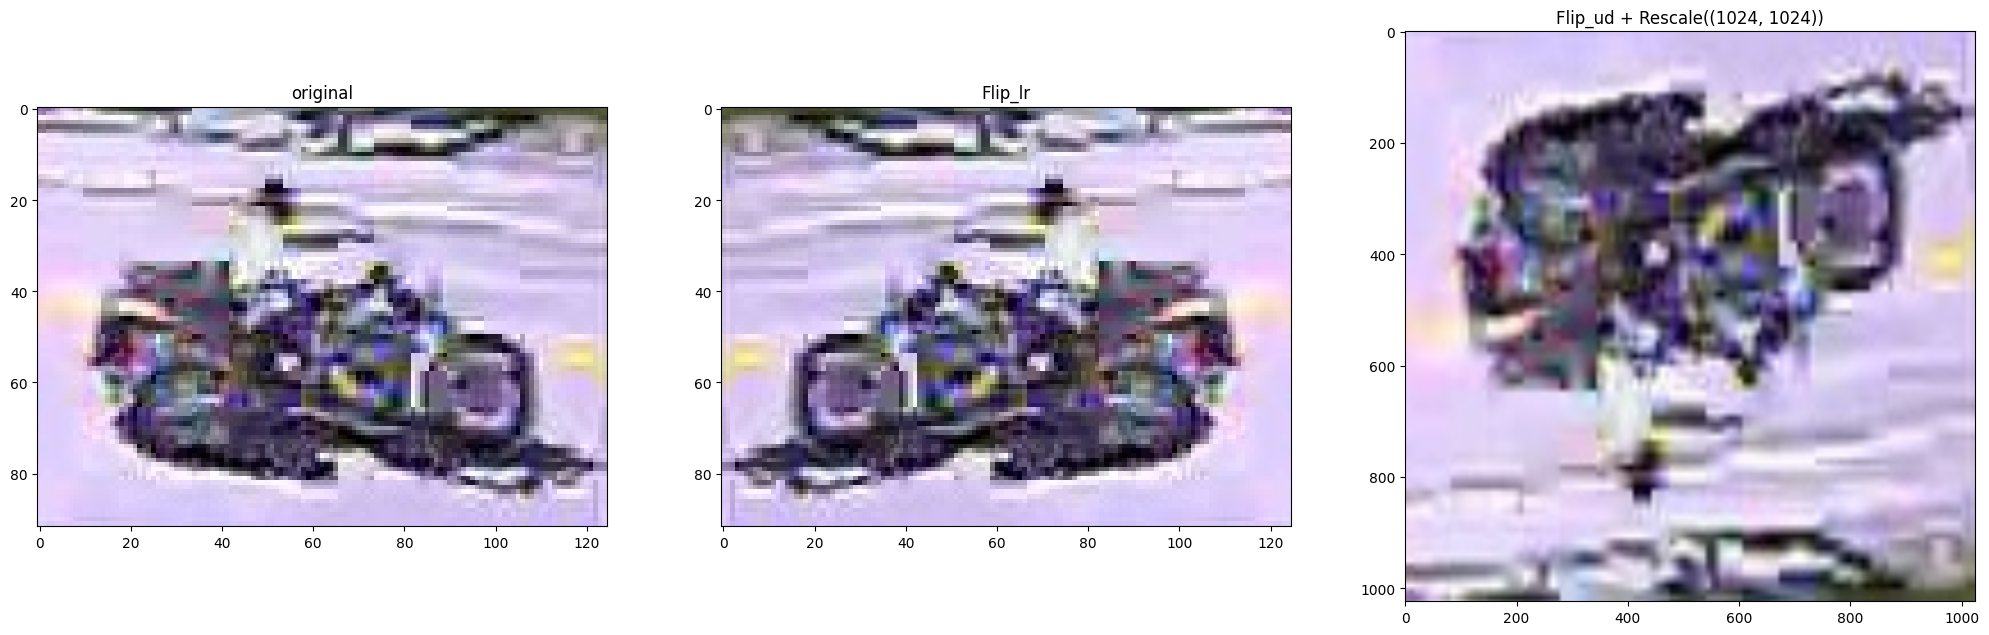

In [180]:
#example on classification
root_dir = "classification"
task = "classification"

composed_transforms = transforms.Compose([Flip(0), Rescale((1024, 1024))])
trans = [None, Flip(1),composed_transforms]
plot_titles = ["original", "Flip_lr", "Flip_ud + Rescale((1024, 1024))"]
samples = []
for t in trans:
  obj = Loader(root_dir, task, t)
  samples.append(obj[0])
plot_sample(samples, plot_titles)

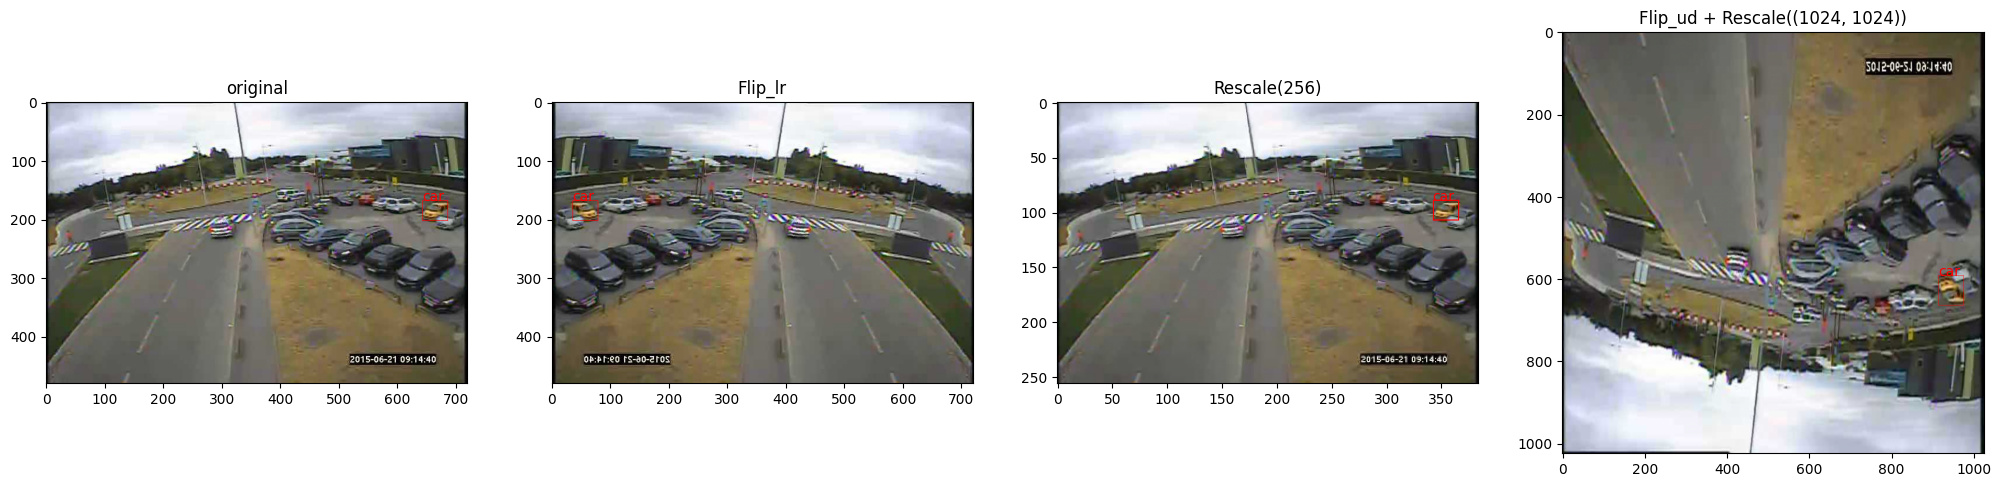

In [181]:
#example on localization
root_dir = "localize"
task = "localization"

composed_transforms = transforms.Compose([Flip(0), Rescale((1024, 1024))])
trans = [None, Flip(1), Rescale(256), composed_transforms]
plot_titles = ["original", "Flip_lr", "Rescale(256)", "Flip_ud + Rescale((1024, 1024))"]
samples = []
for t in trans:
  obj = Loader(root_dir, task, t)
  samples.append(obj[0])
plot_sample(samples, plot_titles)

In [182]:
#example including normalization and tensor
root_dir = "localize"
task = "localization"

composed_transforms = transforms.Compose([Flip(0), Rescale((1024, 1024)),
                                          Normalize(), To_Tensor()])
obj = Loader(root_dir, task, composed_transforms)
sample = obj[0]
print(f"Dictionary keys: {sample.keys()}")
print(f"Image: {sample['image']}\n Image_shape: {sample['image'].shape}")
print(f"image_min:{sample['image'].min()}, image_max:{sample['image'].max()}")
print(f"Bounding Box: {sample['bbox']}")


Dictionary keys: dict_keys(['image', 'class', 'bbox'])
Image: tensor([[[-2.0435, -2.0263, -1.9226,  ..., -1.9399, -1.9054, -1.8881],
         [-2.0435, -2.0263, -1.9226,  ..., -1.9399, -1.9054, -1.8881],
         [-2.0435, -2.0263, -1.9226,  ..., -1.9399, -1.9054, -1.8881],
         ...,
         [-2.0608, -2.0608, -1.9399,  ..., -2.0435, -2.0608, -2.0263],
         [-2.0954, -2.0954, -1.9745,  ..., -2.0435, -2.0608, -2.0263],
         [-2.0954, -2.0954, -1.9745,  ..., -2.0435, -2.0608, -2.0263]],

        [[-2.0323, -2.0153, -1.9302,  ..., -1.9472, -1.9131, -1.8961],
         [-2.0323, -2.0153, -1.9302,  ..., -1.9472, -1.9131, -1.8961],
         [-2.0323, -2.0153, -1.9302,  ..., -1.9472, -1.9131, -1.8961],
         ...,
         [-1.8280, -1.8280, -1.7088,  ..., -1.8620, -1.8620, -1.8109],
         [-1.9131, -1.9131, -1.7769,  ..., -1.8620, -1.8620, -1.8109],
         [-1.8961, -1.8961, -1.7599,  ..., -1.8620, -1.8620, -1.8109]],

        [[-1.6772, -1.6772, -1.6321,  ..., -1.6020, -1

In [183]:
#example including normalization and tensor
root_dir = "classification"
task = "classification"

composed_transforms = transforms.Compose([Flip(0), Rescale((1024, 1024)),
                                          Normalize(), To_Tensor()])
obj = Loader(root_dir, task, composed_transforms)
sample = obj[0]
print(f"Dictionary keys: {sample.keys()}")
print(f"Image: {sample['image']}\n Image_shape: {sample['image'].shape}")
print(f"image_min:{sample['image'].min()}, image_max:{sample['image'].max()}")


Dictionary keys: dict_keys(['image', 'class'])
Image: tensor([[[ 0.8831,  0.8682,  0.8682,  ...,  0.8237,  0.8089,  0.7792],
         [ 0.8682,  0.8682,  0.8682,  ...,  0.8237,  0.8089,  0.7792],
         [ 0.8534,  0.8534,  0.8534,  ...,  0.8237,  0.8089,  0.7792],
         ...,
         [-0.2742, -0.2593, -0.2445,  ..., -1.2089, -1.2089, -1.2089],
         [-0.2593, -0.2297, -0.2148,  ..., -1.2089, -1.2089, -1.2237],
         [-0.2297, -0.2148, -0.1852,  ..., -1.2089, -1.2089, -1.2237]],

        [[ 0.8894,  0.8894,  0.8894,  ...,  0.7502,  0.7347,  0.7038],
         [ 0.8740,  0.8740,  0.8740,  ...,  0.7502,  0.7192,  0.7038],
         [ 0.8585,  0.8585,  0.8740,  ...,  0.7502,  0.7192,  0.7038],
         ...,
         [-0.5649, -0.5494, -0.5339,  ..., -0.9981, -0.9981, -0.9981],
         [-0.5339, -0.5185, -0.5030,  ..., -0.9981, -0.9981, -1.0136],
         [-0.5030, -0.4875, -0.4721,  ..., -0.9981, -1.0136, -1.0136]],

        [[ 0.9962,  0.9962,  0.9962,  ...,  1.0248,  1.0105,  